In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

In [7]:
# 1. 데이터 로드 및 전처리
columns = ['sample_id', 'user_id', 'activity', 'timestamp', 'x_accel', 'y_accel', 'z_accel']
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/machine-learning-practice/Machine-Learning-Programming/week11/data/WISDM.csv', header=None, names=columns)
df

,sample_id,user_id,activity,timestamp,x_accel,y_accel,z_accel
0,0,33,Jogging,4.910600e+13,-0.694638,12.680544,0.503953
1,1,33,Jogging,4.910610e+13,5.012288,11.264028,0.953424
2,2,33,Jogging,4.910610e+13,4.903325,10.882658,-0.081722
3,3,33,Jogging,4.910620e+13,-0.612916,18.496431,3.023717
4,4,33,Jogging,4.910630e+13,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...,...
1048570,1048571,7,Standing,2.091650e+14,-7.930000,5.430000,-0.990000
1048571,1048572,7,Standing,2.091660e+14,-7.970000,5.130000,-1.140000
1048572,1048573,7,Standing,2.091660e+14,-7.970000,5.220000,-1.380000
1048573,1048574,7,Standing,2.091660e+14,-7.930000,5.600000,-1.180000


In [8]:
df.shape

(1048575, 7)

In [9]:
# 불필요한 컬럼 제거
df = df.drop(['sample_id'], axis=1)

In [10]:
# 결측치 홗인

df.isnull().values.any()

np.False_

In [11]:
# '정상' / '이상' 클래스 정의
# 활동(activity) 분포 확인
count_classes = pd.value_counts(df['activity'], sort = True)
print("--- 활동별 데이터 분포 ---")
print(count_classes)
print("--------------------------")

--- 활동별 데이터 분포 ---
activity
Walking       406775
Jogging       325975
Upstairs      118589
Downstairs     97813
Sitting        54876
Standing       44547
Name: count, dtype: int64
--------------------------


/tmp/ipython-input-4040968710.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['activity'], sort = True)


In [12]:
# 가장 빈번한 활동을 '정상' (Normal)으로 정의
NORMAL_CLASS = count_classes.index[0]
print(f"'{NORMAL_CLASS}' 활동을 '정상' (Class=0)으로 정의")

'Walking' 활동을 '정상' (Class=0)으로 정의합니다.


In [13]:
# '정상'은 0, 나머지는 1 (이상)로 변환
df['Class'] = df['activity'].apply(lambda x: 0 if x == NORMAL_CLASS else 1)

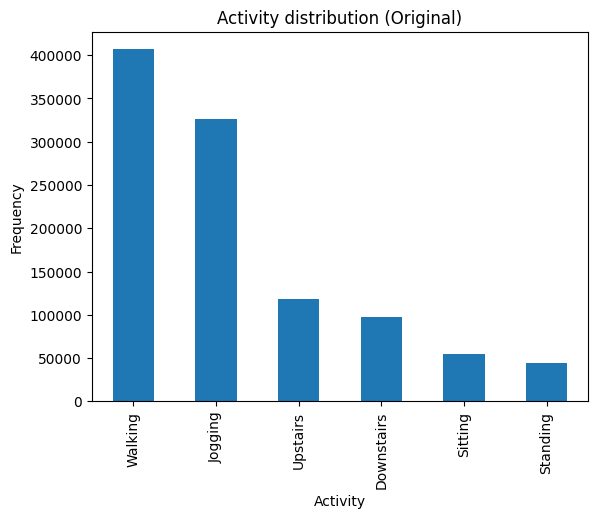

In [14]:
# 시각화 (원본 활동 기준)
count_classes.plot(kind = 'bar', rot=90)
plt.title("Activity distribution (Original)")
plt.xlabel("Activity")
plt.ylabel("Frequency");
plt.show()

/tmp/ipython-input-4241450935.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_binary_classes = pd.value_counts(df['Class'], sort = True)


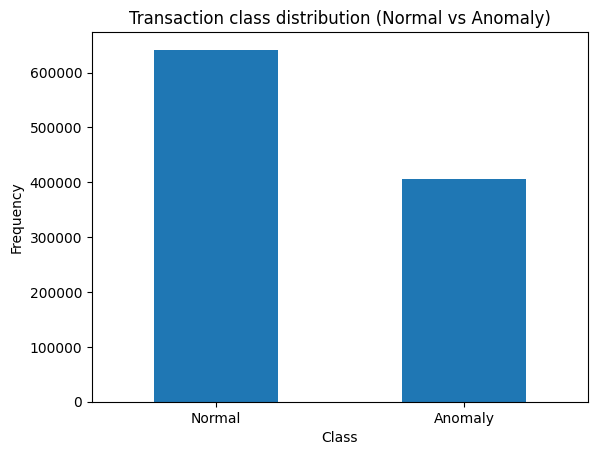

In [15]:
# 시각화 (정상/이상 기준)
LABELS = ["Normal", "Anomaly"]
count_binary_classes = pd.value_counts(df['Class'], sort = True)
count_binary_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution (Normal vs Anomaly)")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");
plt.show()

In [16]:
anomalies = df[df.Class == 1]
normal = df[df.Class == 0]
print(f"Anomaly shape: {anomalies.shape}")
print(f"Normal shape: {normal.shape}")

Anomaly shape: (641800, 7)
Normal shape: (406775, 7)


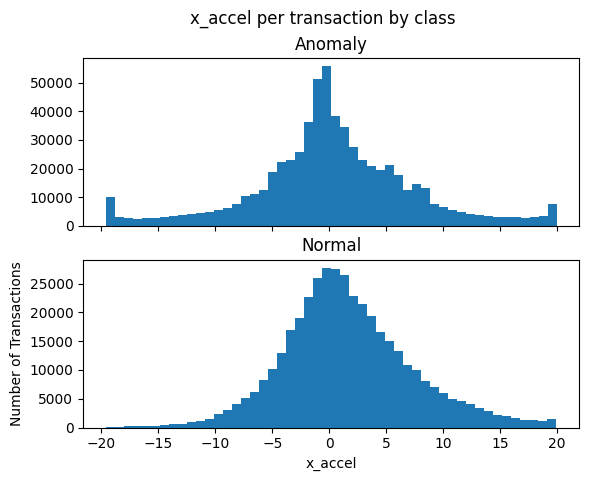

In [17]:
# 3. 피처 시각화 ( creditcard.csv의 'Amount' 대신 'x_accel' 사용)
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('x_accel per transaction by class')

bins = 50

ax1.hist(anomalies.x_accel, bins = bins)
ax1.set_title('Anomaly')

ax2.hist(normal.x_accel, bins = bins)
ax2.set_title('Normal')

plt.xlabel('x_accel')
plt.ylabel('Number of Transactions')
plt.show();

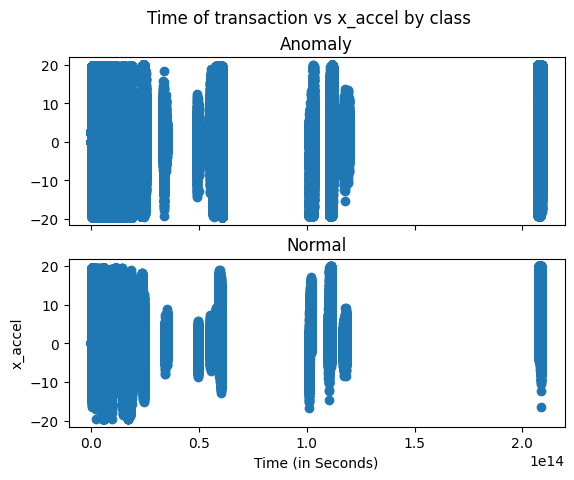

In [18]:
# 'Time' vs 'Amount' 대신 'timestamp' vs 'x_accel'로 시각화
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs x_accel by class')

ax1.scatter(anomalies.timestamp, anomalies.x_accel)
ax1.set_title('Anomaly')

ax2.scatter(normal.timestamp, normal.x_accel)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('x_accel')
plt.show()

In [19]:
# 데이터 스케일링 및 분리
# 'Time' 대신 'timestamp', 'user_id' (범주형이므로) 드랍
# 'activity'는 원본 레이블이므로 드랍
data = df.drop(['timestamp', 'user_id', 'activity'], axis=1)

# 피처 스케일링 (x_accel, y_accel, z_accel)
# Sigmoid 활성화 함수를 위해 0-1 사이로 스케일링
cols_to_scale = ['x_accel', 'y_accel', 'z_accel']
data[cols_to_scale] = MinMaxScaler().fit_transform(data[cols_to_scale])

In [20]:
# 모델을 오직 정상 거래기록으로만 훈련
# 정상 거래기록을 테스트셋에 넣으면 모델의 성능을 평가

RANDOM_SEED = 42

In [21]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (325604, 3)
X_test shape: (209715, 3)


In [22]:
# 오토인코더 모델 정의
# 입력 차원이 3 (x, y, z)이므로, 은닉층 크기를 대폭 줄임
input_dim = X_train.shape[1]  # 3
encoding_dim = 2              # 입력 차원(3)보다 작은 값 (예: 2)
middle_dim = 1                # encoding_dim / 2

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
encoded = Dense(middle_dim, activation='relu')(encoded)
decoded = Dense(middle_dim, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded) # MinMaxScaler와 매칭

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19 (76.00 B)

 Trainable params: 19 (76.00 B)

 Non-trainable params: 0 (0.00 B)

In [23]:
# 훈련데이터의 0.1 을 validation data로 사용
history = autoencoder.fit(X_train, X_train,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_split = 0.1)

Epoch 1/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0246 - val_loss: 0.0163
Epoch 2/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0161 - val_loss: 0.0158
Epoch 3/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0159 - val_loss: 0.0158
Epoch 4/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0159 - val_loss: 0.0158
Epoch 5/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0159 - val_loss: 0.0158
Epoch 6/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0159 - val_loss: 0.0158
Epoch 7/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0159 - val_loss: 0.0158
Epoch 8/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0158 - val_loss: 0.0158
Epoch 9/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0159 - val_loss: 0.0158
Epoch 10/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0159 - val_loss: 0.0158
Epoch 11/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0159 - val_loss: 0.0158
Epoch 12/50
1145/1145 ━━━━━━━━

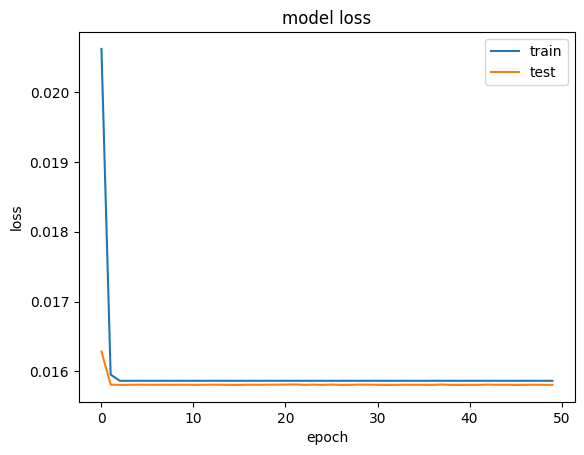

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [25]:
# X_test 값을 넣어서 Reconstruction Error 값을 얻고,
# 실제 레이블인 y_test와 데이터프레임으로 구성
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                         'true_class': y_test})
print(error_df.describe())

6554/6554 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
       reconstruction_error     true_class
count         209715.000000  209715.000000
mean               0.024746       0.612946
std                0.031207       0.487077
min                0.000001       0.000000
25%                0.005170       0.000000
50%                0.014058       1.000000
75%                0.030926       1.000000
max                0.320132       1.000000


In [26]:
# threshold 값을 조정하여 최선의 정확도를 얻음, 그래프로를 보고 결정
# MSE 손실이고 0-1 스케일이므로 15보다 훨씬 작은 값이어야 함
# error_df.describe()를 보고 95% 분위수(quantile) 등을 참고
threshold = 0.05  # 예시 값, 반드시 조정 필요
print(f"설정된 Threshold: {threshold}")

설정된 Threshold: 0.05


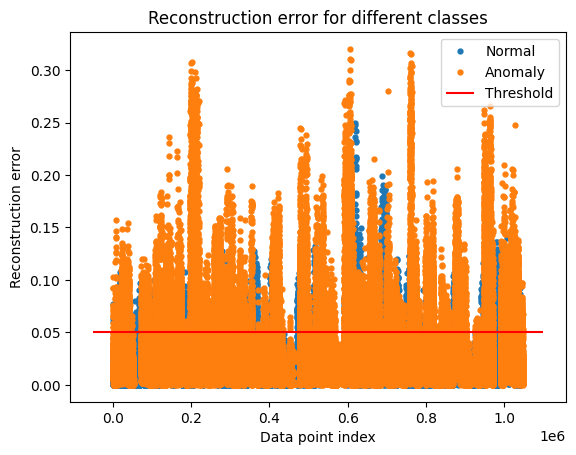

In [27]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Anomaly" if name == 1 else "Normal") # 레이블 수정
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

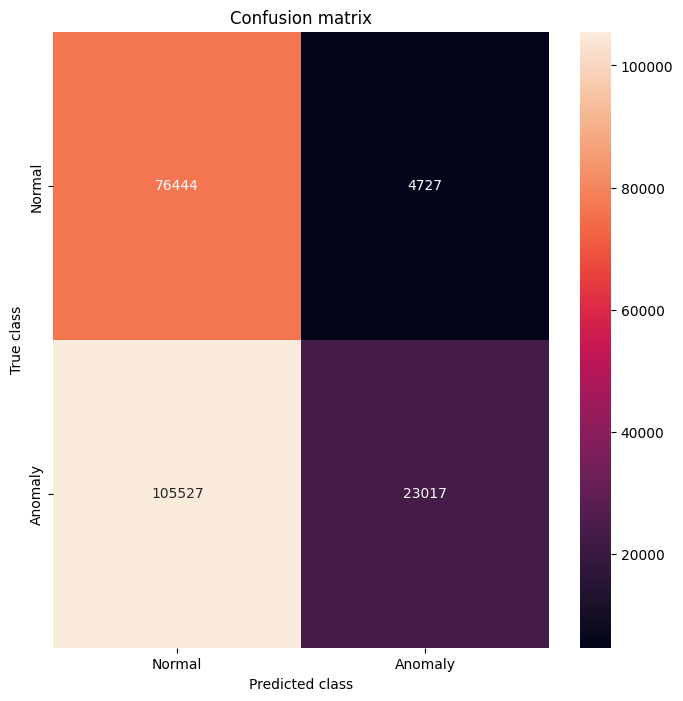

              precision    recall  f1-score   support

           0       0.42      0.94      0.58     81171
           1       0.83      0.18      0.29    128544

    accuracy                           0.47    209715
   macro avg       0.62      0.56      0.44    209715
weighted avg       0.67      0.47      0.41    209715



In [28]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

print(classification_report(error_df.true_class, y_pred))